# World Heritage Outlook analysis 2.0 - 2017 assessment cycle

## Updates
- 170724 Run
- 170817 Run 

## About

The 2017 cycle of assessments will not be ready until later September/October, leaving little time for analysis and for the report. This notebook is an attempt to:

1. Experiment the methodology that allows rapid analysis to be repeated with little efforts. The goal is to complete the analysis within short time, when the final data have become available
2. Experiment open and reproducible analysis that anyone interested could critique, repeat or improve the methodolgy if they so wish
3. Test ideas and scrutise the result, to uncover inconsistency and enable future iterations of outlook assessment to be more systematic and consistent

### So far
- load CSV data (pre-processed data dumps from PostgreSQL/MS Access) into the notebook
- utility functions to find relevant rows in the data, based on `wdpaid` and `assessment_cycle`
- generic summary statistics (using `pandas.DataFrame.pivot_table`), for the `overall` table, notably including the `outlook` ratings. This is implemented so that any dataframe with filtered rows could be done easily, i.e., allowing subsetting by regions, countries, any attribute criteria
- generic field-by-field change detction for the `overall` table. This is useful to identify the lowest level change (i.e. field level change for each site) but also provides a mechanism for quality control as odd changes that should not happen could be easily identified
- generic pivot table counting for any data. I tested the functionality using `potential_threat`, in which different groups of threat categories are needed
- viz: outlook, and its comparison
- viz: heatmap for threats, the charts are interactive, allowing users to interrogate each cell (powered by Plot.ly)
- finding associations between values, pm and threats to the final outlook rating
- finding inconsistencies between individual threat listing and severity to the final threat rating 
    
### Ideas
- attribute filters: regions, marine, country, WH criteria, danger status. This could be easily implemented as the only change would be the input. As long as the analysis is designed in such a way that allow such input to be changed at a later stage.
- find sites and analyse based on internal filters, such as specific threats or management


## Data preparation and exploration

In [1]:
import os, sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# %matplotlib inline

import plotly library for plotting

In [3]:
import plotly
plotly.tools.set_credentials_file(username='yichuans', api_key='DjWuYpvtG8nFh8A9U8Jb')

# ensure offline viewing of plotly graphs
# plotly.offline.init_notebook_mode(connected=True)

import plotly.plotly as py
import plotly.figure_factory as ff

from plotly.graph_objs import Bar

In [4]:
!ls

Draft analysis.ipynb           potential_threat.csv
WH_attributes_2017.csv         protection_management.csv
changed_statistics.csv         temp-plot.html
current_threat.csv             who_value_current_threat.csv
old                            who_value_potential_threat.csv
overall.csv


Loading data into dataframes

In [5]:
overall = pd.read_csv('overall.csv', encoding='latin1')
current_threat = pd.read_csv('current_threat.csv', encoding='latin1')
potential_threat = pd.read_csv('potential_threat.csv', encoding='latin1')
protection_management = pd.read_csv('protection_management.csv', encoding='latin1')
value_current_threat = pd.read_csv('who_value_current_threat.csv', encoding='latin1')
value_potential_threat = pd.read_csv('who_value_potential_threat.csv', encoding='latin1')
wh_attr = pd.read_csv('WH_attributes_2017.csv')

In [6]:
potential_threat.columns

Index([u'wdpa_id', u'screenname', u'status', u'stage', u'name_en',
       u'threat_category', u'threat_sub_category', u'potential_threat',
       u'rating', u'inside_site', u'outside_site', u'assessment_cycle'],
      dtype='object')

In [7]:
value_current_threat.columns

Index([u'wdpa_id', u'assessment_version_id', u'screenname', u'status',
       u'stage', u'name_en', u'values_', u'criterion', u'current_threat',
       u'threat_category', u'threat_sub_category', u'assessment_cycle'],
      dtype='object')

In [8]:
overall.columns

Index([u'wdpa_id', u'screenname', u'status', u'stage', u'name_en', u'outlook',
       u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt',
       u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language',
       u'assessment_cycle'],
      dtype='object')

In [9]:
current_threat.columns

Index([u'wdpa_id', u'screenname', u'status', u'stage', u'name_en',
       u'threat_category', u'threat_sub_category', u'rating', u'inside_site',
       u'outside_site', u'assessment_version_id', u'assessment_cycle'],
      dtype='object')

In [10]:
current_threat.dtypes

wdpa_id                    int64
screenname                object
status                    object
stage                     object
name_en                   object
threat_category           object
threat_sub_category       object
rating                    object
inside_site              float64
outside_site             float64
assessment_version_id      int64
assessment_cycle           int64
dtype: object

In [11]:
overall.dtypes

wdpa_id              int64
screenname          object
status              object
stage               object
name_en             object
outlook             object
overall_threat      object
current_threat      object
potential_threat    object
prot_mgmt           object
wh_value            object
wh_trend            object
biodiv_value        object
biodiv_trend        object
language             int64
assessment_cycle     int64
dtype: object

In [12]:
overall.index.size, overall.wdpa_id.nunique()

(438, 237)

In [13]:
protection_management[pd.isnull(protection_management.pm_rating)]

,wdpa_id,screenname,status,stage,name_en,topic,pm_rating,assessment_cycle
3053,10902,tilman,Completed,Assessment,Wood Buffalo National Park,Assessment of the effectiveness of protection ...,NaN,2017
3229,61609,elena,Completed,Assessment,Bwindi Impenetrable National Park,Assessment of the effectiveness of protection ...,NaN,2017
3243,555556048,elena,Completed,Assessment,Namib Sand Sea,Assessment of the effectiveness of protection ...,NaN,2017
3262,555577555,alan,Completed,Assessment,Okavango Delta,Assessment of the effectiveness of protection ...,NaN,2017
3270,903138,tarek,Completed,Assessment,Socotra Archipelago,Assessment of the effectiveness of protection ...,NaN,2017
3298,902487,tarek,Completed,Assessment,Wadi Al-Hitan (Whale Valley),Assessment of the effectiveness of protection ...,NaN,2017
3302,4999,tarek,Completed,Assessment,Tassili n'Ajjer National Park,Assessment of the effectiveness of protection ...,NaN,2017
3319,555542337,tarek,Completed,Assessment,Wadi Rum Protected Area,Assessment of the effectiveness of protection ...,NaN,2017
3340,93767,alexbond,Completed,Assessment,Gough and Inaccessible Islands,Assessment of the effectiveness of protection ...,NaN,2017
3365,902479,wendy,Completed,Assessment,Coiba National Park and its Special Zone of Ma...,Assessment of the effectiveness of protection ...,NaN,2017


In [14]:
protection_management.head()

,wdpa_id,screenname,status,stage,name_en,topic,pm_rating,assessment_cycle
0,2010,elena,Completed,Published,Ngorongoro Conservation Area,Relationships with local people (including sta...,Effective,2014
1,2010,elena,Completed,Published,Ngorongoro Conservation Area,Legal framework,Effective,2014
2,2010,elena,Completed,Published,Ngorongoro Conservation Area,Integration into regional and national plannin...,Effective,2014
3,2010,elena,Completed,Published,Ngorongoro Conservation Area,Management system (for transboundary/serial pr...,Highly Effective,2014
4,2010,elena,Completed,Published,Ngorongoro Conservation Area,Management effectiveness,Effective,2014


In [15]:
value_current_threat.head()

,wdpa_id,assessment_version_id,screenname,status,stage,name_en,values_,criterion,current_threat,threat_category,threat_sub_category,assessment_cycle
0,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Alien Invasive Species,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,2014
1,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Extreme weather events,Climate Change and Severe Weather,Storms/Flooding,2014
2,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Marine pollution and garbage,Pollution,Water Pollution,2014
3,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Alien Invasive Species,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,2014
4,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Marine pollution and garbage,Pollution,Water Pollution,2014


In [16]:
value_potential_threat.head()

,wdpa_id,assessment_version_id,screenname,status,stage,name_en,values_,criterion,potential_threat,threat_category,threat_sub_category,assessment_cycle
0,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Climate change,Climate Change and Severe Weather,Ocean acidification,2014
1,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Climate change,Climate Change and Severe Weather,Temperature extremes,2014
2,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Climate change,Climate Change and Severe Weather,Temperature extremes,2014
3,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Climate change,Climate Change and Severe Weather,Ocean acidification,2014
4,26653,4302,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Unique and spectacular geomorphological features,7,Climate change,Climate Change and Severe Weather,Ocean acidification,2014


## Overall conservation outlook

Filters for 2014 and 2017 cycles of assessment

In [17]:
CYCLE_2017_OVERALL = overall.assessment_cycle == 2017
CYCLE_2014_OVERALL = overall.assessment_cycle == 2014

In [18]:
overall.head()

,wdpa_id,screenname,status,stage,name_en,outlook,overall_threat,current_threat,potential_threat,prot_mgmt,wh_value,wh_trend,biodiv_value,biodiv_trend,language,assessment_cycle
0,2010,elena,Completed,Published,Ngorongoro Conservation Area,Good with some concerns,Low Threat,High Threat,Low Threat,Effective,Low Concern,Stable,NaN,NaN,1,2014
1,17761,elena,Completed,Published,Kilimanjaro National Park,Good with some concerns,Low Threat,Low Threat,NaN,Effective,Low Concern,Deteriorating,Data Deficient,Data Deficient,1,2014
2,2580,elena,Completed,Published,Niokolo-Koba National Park,Critical,Very High Threat,Very High Threat,High Threat,Serious Concern,Critical,Data Deficient,Critical,Data Deficient,2,2014
3,902487,elena,Completed,Published,Wadi Al-Hitan (Whale Valley),Good,Low Threat,Low Threat,Data Deficient,Effective,Good,Stable,NaN,NaN,1,2014
4,67727,elena,Completed,Translated,Aïr and Ténéré Natural Reserves,Critical,Very High Threat,Very High Threat,Data Deficient,Serious Concern,Critical,Deteriorating,NaN,NaN,1,2014


The number of unique records for 2014 and 2017 cycles

In [19]:
overall[CYCLE_2014_OVERALL].wdpa_id.nunique(), overall[CYCLE_2017_OVERALL].wdpa_id.nunique()

(229, 209)

Quality checks on the data: what are the sites that are in 2014 but not in 2017 and vice versa? Or what is the number of sites that have two assessments?

In [20]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id.values)
print('Total number of shared sites between two cycles: {}'.format(wdpaid_shared_between_cycles.sum()))

Total number of shared sites between two cycles: 201


### Overall outlook statistics

In [21]:
overall[CYCLE_2014_OVERALL].pivot_table(values='wdpa_id', columns='outlook', aggfunc=np.count_nonzero)

outlook,Critical,Good,Good with some concerns,Significant Concern
wdpa_id,19,47,96,67


In [22]:
## create a more generic version of get number statistics
def summary_statistics(df, columns, aggfunc=np.count_nonzero):
    result = df.pivot_table(values='wdpa_id', columns=columns, aggfunc=aggfunc)
    result.index = [' '] # remove wdpa_id as index value
    return result

In [23]:
pd.DataFrame.pivot_table(overall, columns='outlook', values='wdpa_id', aggfunc=np.count_nonzero)

outlook,Critical,Good,Good with some concerns,Significant Concern
wdpa_id,32,82,186,133


In [24]:
pd.DataFrame.pivot_table(overall, index='outlook', values='wdpa_id', aggfunc=np.count_nonzero)

,wdpa_id
outlook,
Critical,32
Good,82
Good with some concerns,186
Significant Concern,133


In [25]:
summary_statistics(overall, columns=['outlook'])

outlook,Critical,Good,Good with some concerns,Significant Concern
,32,82,186,133


In [26]:
overall[CYCLE_2014_OVERALL].columns

Index([u'wdpa_id', u'screenname', u'status', u'stage', u'name_en', u'outlook',
       u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt',
       u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language',
       u'assessment_cycle'],
      dtype='object')

In [27]:
summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook')

outlook,Critical,Good,Good with some concerns,Significant Concern
,19,47,96,67


In [28]:
a = summary_statistics(overall[CYCLE_2014_OVERALL], 'current_threat')

In [29]:
type(a)

pandas.core.frame.DataFrame

In [30]:
cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    print summary_statistics(overall[CYCLE_2014_OVERALL], col)

status  Completed  In Progress
              228            1
stage  Approved  Assessment  Published  Translated
              1           1        224           3
outlook  Critical  Good  Good with some concerns  Significant Concern
               19    47                       96                   67
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         90          88                33               18
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         89          91                30               19
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              26           84          71                24   

potential_threat  Very Low Threat  
                               15  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                 103                23               29            74
wh_value  Critical  Good 

In [31]:
cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    print summary_statistics(overall[CYCLE_2017_OVERALL], col)

status  Completed  In Progress
               88          121
stage  Assessment  Review
              200       9
outlook  Critical  Good  Good with some concerns  Significant Concern
               13    35                       90                   66
overall_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             1           86          74                29   

overall_threat  Very Low Threat  
                             14  
current_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             2           85          77                27   

current_threat  Very Low Threat  
                             13  
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              21           76          70                20   

potential_threat  Very Low Threat  
                                9  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern

By adding further filters, such as regions/countries/(other attributes), in the form of list of wdpaids, it can calculate statistics reusing the `summary_statistics` function. TBD: apply wdpaid filter, perhaps `isin`

### Overall outlook viz
Investigate visualisation options

In [32]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [33]:
plt.style.use('ggplot')

In [34]:
summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook').plot.barh(stacked=True)

In [35]:
def plot_outlook(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red]
    my_labels = ['Good', 'Good with some concerns', 'Significant Concern', 'Critical']
    data = df[my_labels]

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

In [36]:
## a genric plot function, requiring the scheme to be sorted before hand
def plot_summary_statistics(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red, grey]
    my_labels = df.columns
    data = df

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

**overall outlook 2014 - 2017**

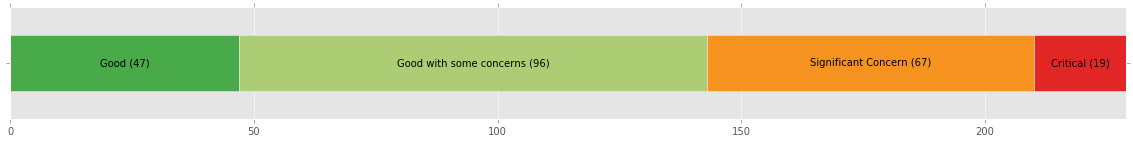

In [37]:
plot_outlook(summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook'))

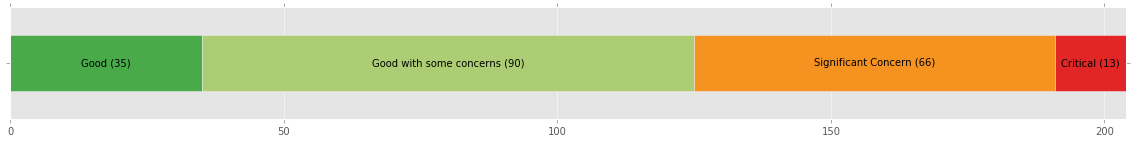

In [38]:
plot_outlook(summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook'))

Testing generic statistics ploting function, noting the need to re-order columns

**potential threat 2014 - 2017**

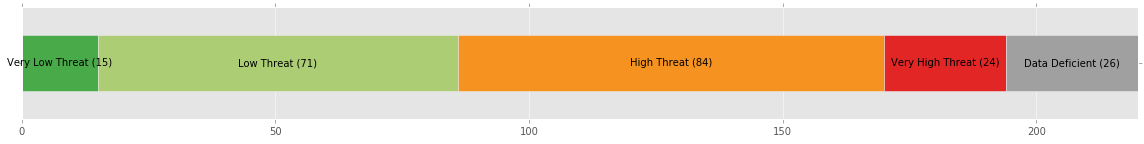

In [39]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

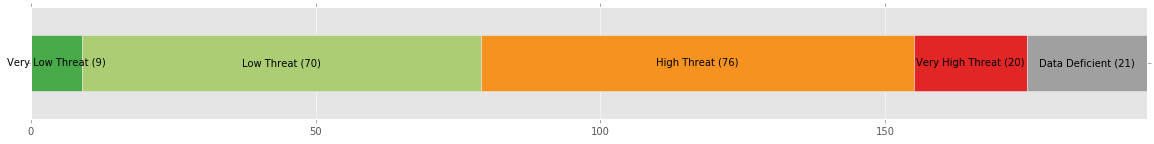

In [40]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**current threat 2014 - 2017**

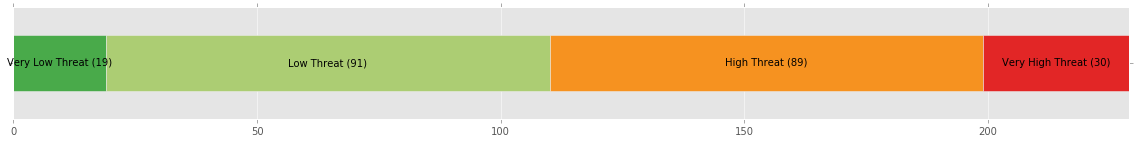

In [41]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat']])

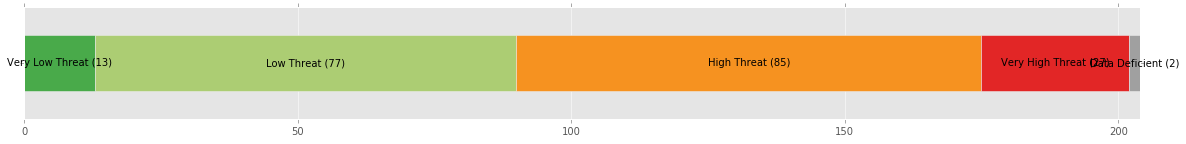

In [42]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

### Detect change from 2014 and 2017

It would be desirable during analysis to understand what change may have happened for each site (if any) 

In [43]:
b = overall[overall.wdpa_id == 191]

In [44]:
b

,wdpa_id,screenname,status,stage,name_en,outlook,overall_threat,current_threat,potential_threat,prot_mgmt,wh_value,wh_trend,biodiv_value,biodiv_trend,language,assessment_cycle
171,191,elena,Completed,Published,Galápagos Islands,Significant Concern,Very High Threat,Very High Threat,Very High Threat,Effective,High Concern,Deteriorating,High Concern,Deteriorating,1,2014
257,191,wendy,In Progress,Assessment,Galápagos Islands,Significant Concern,Very High Threat,Very High Threat,Very High Threat,Effective,High Concern,Deteriorating,High Concern,Deteriorating,1,2017


In [45]:
def bb(df):
    ## 0 indicate different values in the series
    if df.screenname.duplicated(False).sum() == 0:
        return df.outlook
    ## either same value or one value only (only one cycle of assessment)
    else:
        return pd.Series(['-'])
    
# def apply_comparison(df):
#     df[field]

In [46]:
for key, group in b.groupby('wdpa_id'):
    print key, group

191      wdpa_id screenname       status       stage            name_en  \
171      191      elena    Completed   Published  Galápagos Islands   
257      191      wendy  In Progress  Assessment  Galápagos Islands   

                 outlook    overall_threat    current_threat  \
171  Significant Concern  Very High Threat  Very High Threat   
257  Significant Concern  Very High Threat  Very High Threat   

     potential_threat  prot_mgmt      wh_value       wh_trend  biodiv_value  \
171  Very High Threat  Effective  High Concern  Deteriorating  High Concern   
257  Very High Threat  Effective  High Concern  Deteriorating  High Concern   

      biodiv_trend  language  assessment_cycle  
171  Deteriorating         1              2014  
257  Deteriorating         1              2017  


In [47]:
b.groupby('wdpa_id').apply(bb)

outlook,171,257
wdpa_id,,
191,Significant Concern,Significant Concern


try a different way to detect changes

In [48]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id.values)

In [49]:
common_wdpaids = overall[CYCLE_2014_OVERALL].wdpa_id[wdpaid_shared_between_cycles]

In [50]:
overall.columns.tolist()

[u'wdpa_id',
 u'screenname',
 u'status',
 u'stage',
 u'name_en',
 u'outlook',
 u'overall_threat',
 u'current_threat',
 u'potential_threat',
 u'prot_mgmt',
 u'wh_value',
 u'wh_trend',
 u'biodiv_value',
 u'biodiv_trend',
 u'language',
 u'assessment_cycle']

Only the WDPAID is the unique identifier re rows, but en_name is useful for checks

In [51]:
def detect_change_col(wdpaid, df, col):
    """"one row per cycle, i.e. one to one relationship"""
    # brutal force not efficient, first row
    value_2017 = df[(df.assessment_cycle==2017) & (df.wdpa_id==wdpaid)][col].iloc[0]
    value_2014 = df[(df.assessment_cycle==2014) & (df.wdpa_id==wdpaid)][col].iloc[0]
    
    if value_2017 == value_2014:
        return None
    
    # if both variables are of type float and nan, don't do anything
    elif isinstance(value_2017, float) and isinstance(value_2014, float):
        if math.isnan(value_2017) and math.isnan(value_2014):
            return None
        
    # detected change, record
    else:
        return ' -> '.join(map(str, [value_2014, value_2017]))

def detect_change_df(df):
    output = list()
    
    # go through all fields and remove unnecesary fields
    excluded_cols = ['wdpa_id', 'screenname', 'status', 'stage', 'assessment_cycle']
    cols = df.columns.tolist()

    for excluded_col in excluded_cols:
        if excluded_col in cols:
            cols.remove(excluded_col)
    
    # for each site do detection check
    for wdpaid in common_wdpaids:
        for col in cols:
            result = detect_change_col(wdpaid, df, col)
            # if detected
            if result:
                output.append([wdpaid, col, result])
    
    # append en_name 
    output_df = pd.DataFrame(data=output, columns=['wdpaid', 'column', 'value'])
    output_full = pd.merge(output_df, wh_attr, how='inner', on='wdpaid')[['wdpaid', 'en_name', 'column', 'value']]
    
    return output_full

In [52]:
changed_stats = detect_change_df(overall)

In [53]:
changed_stats.to_csv('changed_statistics.csv', encoding='utf-8')

In [54]:
changed_stats.dtypes

wdpaid      int64
en_name    object
column     object
value      object
dtype: object

In [55]:
changed_stats

,wdpaid,en_name,column,value
0,2010,Ngorongoro Conservation Area,biodiv_value,nan -> Low Concern
1,2010,Ngorongoro Conservation Area,biodiv_trend,nan -> Data Deficient
2,17761,Kilimanjaro National Park,biodiv_value,Data Deficient -> Low Concern
3,17761,Kilimanjaro National Park,biodiv_trend,Data Deficient -> Deteriorating
4,902487,Wadi Al-Hitan (Whale Valley),outlook,Good -> Good with some concerns
5,67727,Aïr and Ténéré Natural Reserves,potential_threat,Data Deficient -> High Threat
6,67727,Aïr and Ténéré Natural Reserves,prot_mgmt,Serious Concern -> Some Concern
7,67727,Aïr and Ténéré Natural Reserves,language,1 -> 2
8,61608,Rwenzori Mountains National Park,prot_mgmt,Effective -> Some Concern
9,4322,Ichkeul National Park,language,2 -> 1


`pd.pivot` can be used to identify site specific change for all fields. Note the `columns` argument that for each value in the column would be made a column in the resulting pivot table

In [56]:
# pd.pivot?

In [57]:
changed_stats.pivot( 'en_name', columns='column', values='value')

column,biodiv_trend,biodiv_value,current_threat,language,outlook,overall_threat,potential_threat,prot_mgmt,wh_trend,wh_value
en_name,,,,,,,,,,
Aïr and Ténéré Natural Reserves,None,None,None,1 -> 2,None,None,Data Deficient -> High Threat,Serious Concern -> Some Concern,None,None
Brazilian Atlantic Islands: Fernando de Noronha and Atol das Rocas Reserves,None,None,Low Threat -> High Threat,None,None,None,High Threat -> Low Threat,None,Data Deficient -> Stable,None
Bwindi Impenetrable National Park,nan -> Stable,nan -> Data Deficient,None,None,None,None,None,None,None,None
Canadian Rocky Mountain Parks,Stable -> Deteriorating,Low Concern -> High Concern,Low Threat -> High Threat,None,Good with some concerns -> Significant Concern,Low Threat -> High Threat,None,Effective -> Serious Concern,Stable -> Deteriorating,Good -> High Concern
Canaima National Park,None,High Concern -> Data Deficient,High Threat -> Very High Threat,None,None,High Threat -> Very High Threat,Very High Threat -> Data Deficient,None,None,None
Cape Floral Region Protected Areas,None,None,None,None,Good with some concerns -> Significant Concern,None,None,Effective -> Some Concern,Stable -> Deteriorating,None
Carlsbad Caverns National Park,Data Deficient -> Improving,High Concern -> Low Concern,None,None,None,None,None,None,None,None
Caves of Aggtelek Karst and Slovak Karst,None,None,Very Low Threat -> Low Threat,None,Good -> Good with some concerns,None,None,None,None,None
Central Sikhote-Alin,None,None,Very High Threat -> High Threat,None,Significant Concern -> Good with some concerns,High Threat -> Low Threat,None,Some Concern -> Highly Effective,Deteriorating -> Stable,High Concern -> Low Concern


SQL term `group by` are equivalent to the pivot table `index`. 

In [58]:
pd.pivot_table(changed_stats, values='wdpaid', index='value', aggfunc=np.count_nonzero)

,wdpaid
value,
1 -> 2,4
1 -> 3,1
2 -> 1,1
Critical -> High Concern,1
Critical -> Significant Concern,2
Critical -> nan,1
Data Deficient -> Deteriorating,4
Data Deficient -> High Threat,2
Data Deficient -> Improving,3


## Utility functions

Find rows in threat table

In [59]:
def find_threat_rows(wdpaid, cycle, current=True):
    if current:
        table = current_threat
    else:
        table = potential_threat
        
    return table[(table.assessment_cycle == cycle) & (table.wdpa_id == wdpaid)]

In [60]:
find_threat_rows(191, 2014)

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,rating,inside_site,outside_site,assessment_version_id,assessment_cycle
1156,191,elena,Completed,Published,Galápagos Islands,Transportation and Service Corridors,Shipping Lanes,High Threat,1.0,1.0,5742,2014
1158,191,elena,Completed,Published,Galápagos Islands,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,Very High Threat,1.0,0.0,5742,2014
1159,191,elena,Completed,Published,Galápagos Islands,Human Intrusions and Disturbance,Tourism/ visitors/ recreation,Very High Threat,1.0,0.0,5742,2014
1160,191,elena,Completed,Published,Galápagos Islands,Biological Resource Use,Fishing / Harvesting Aquatic Resources,High Threat,1.0,0.0,5742,2014
1493,191,elena,Completed,Published,Galápagos Islands,Climate Change and Severe Weather,Temperature extremes,High Threat,1.0,0.0,5742,2014


In [61]:
potential_threat.head()

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle
0,478640,elena,Completed,Published,Hierapolis-Pamukkale,Geological Events,Earthquakes/ Tsunamis,Earthquakes,Low Threat,1.0,0.0,2014
1,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Habitat Shifting/ Alteration,Habitat shifting,Data Deficient,0.0,0.0,2014
2,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Droughts,Changes to rainfall patterns,Data Deficient,0.0,0.0,2014
3,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Temperature extremes,Temperature changes,Data Deficient,0.0,0.0,2014
4,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Energy Production and Mining,Oil/ Gas exploration/development,Oil and gas,Data Deficient,0.0,0.0,2014


Use a python closure to generate a set of utility functions that find rows in any given table, based on the `wdpaid` and the `assessnment_cycle` fields

In [62]:
def gen_find_df_records(df):
    # generate functions for inspection
    if 'wdpa_id' not in df.columns.tolist() or 'assessment_cycle' not in df.columns.tolist():
        raise Exception('wdpa_id or assessment_cycle not present in the input dataframe')
    
    def find_df_records(wdpaid, cycle):
        return df[(df.assessment_cycle == cycle) & (df.wdpa_id == wdpaid)]
        
    return find_df_records
    

In [63]:
find_pm = gen_find_df_records(protection_management)

In [64]:
find_pm(191, 2014)

,wdpa_id,screenname,status,stage,name_en,topic,pm_rating,assessment_cycle
2394,191,elena,Completed,Published,Galápagos Islands,Relationships with local people (including sta...,Some Concern,2014
2395,191,elena,Completed,Published,Galápagos Islands,Legal framework,Some Concern,2014
2396,191,elena,Completed,Published,Galápagos Islands,Integration into regional and national plannin...,Some Concern,2014
2397,191,elena,Completed,Published,Galápagos Islands,Management system (for transboundary/serial pr...,Effective,2014
2398,191,elena,Completed,Published,Galápagos Islands,Management effectiveness,Some Concern,2014
2399,191,elena,Completed,Published,Galápagos Islands,Implementation of Committee decisions and reco...,Some Concern,2014
2400,191,elena,Completed,Published,Galápagos Islands,Boundaries,Effective,2014
2401,191,elena,Completed,Published,Galápagos Islands,Sustainable finance,Effective,2014
2402,191,elena,Completed,Published,Galápagos Islands,Staff training and development,Serious Concern,2014
2403,191,elena,Completed,Published,Galápagos Islands,Sustainable use,Some Concern,2014


In [65]:
find_overall = gen_find_df_records(overall)
find_current_threat = gen_find_df_records(current_threat)
find_potential_threat = gen_find_df_records(potential_threat)
find_protection_management = gen_find_df_records(protection_management)
find_value_current_threat = gen_find_df_records(value_current_threat)
find_value_potential_threat = gen_find_df_records(value_potential_threat)

In [66]:
find_overall(191,2014)

,wdpa_id,screenname,status,stage,name_en,outlook,overall_threat,current_threat,potential_threat,prot_mgmt,wh_value,wh_trend,biodiv_value,biodiv_trend,language,assessment_cycle
171,191,elena,Completed,Published,Galápagos Islands,Significant Concern,Very High Threat,Very High Threat,Very High Threat,Effective,High Concern,Deteriorating,High Concern,Deteriorating,1,2014


In [67]:
find_current_threat(191,2014)

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,rating,inside_site,outside_site,assessment_version_id,assessment_cycle
1156,191,elena,Completed,Published,Galápagos Islands,Transportation and Service Corridors,Shipping Lanes,High Threat,1.0,1.0,5742,2014
1158,191,elena,Completed,Published,Galápagos Islands,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,Very High Threat,1.0,0.0,5742,2014
1159,191,elena,Completed,Published,Galápagos Islands,Human Intrusions and Disturbance,Tourism/ visitors/ recreation,Very High Threat,1.0,0.0,5742,2014
1160,191,elena,Completed,Published,Galápagos Islands,Biological Resource Use,Fishing / Harvesting Aquatic Resources,High Threat,1.0,0.0,5742,2014
1493,191,elena,Completed,Published,Galápagos Islands,Climate Change and Severe Weather,Temperature extremes,High Threat,1.0,0.0,5742,2014


In [68]:
find_current_threat(191, 2017)

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,rating,inside_site,outside_site,assessment_version_id,assessment_cycle
1621,191,wendy,In Progress,Assessment,Galápagos Islands,Transportation and Service Corridors,Shipping Lanes,High Threat,1.0,1.0,6966,2017
1697,191,wendy,In Progress,Assessment,Galápagos Islands,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,Very High Threat,1.0,0.0,6966,2017
1698,191,wendy,In Progress,Assessment,Galápagos Islands,Human Intrusions and Disturbance,Tourism/ visitors/ recreation,Very High Threat,1.0,0.0,6966,2017
1699,191,wendy,In Progress,Assessment,Galápagos Islands,Biological Resource Use,Fishing / Harvesting Aquatic Resources,High Threat,1.0,0.0,6966,2017
1701,191,wendy,In Progress,Assessment,Galápagos Islands,Climate Change and Severe Weather,Temperature extremes,High Threat,1.0,0.0,6966,2017


In [69]:
# potential threat of id 2008, in assessment cycle 2014
find_potential_threat(2008, 2014)

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle
394,2008,elena,Completed,Published,Bialowieza Forest,Climate Change and Severe Weather,Temperature extremes,Changes in temperature and precipitation,Data Deficient,1.0,1.0,2014
395,2008,elena,Completed,Published,Bialowieza Forest,Natural System Modifications,Fire/ Fire Suppression,Forest fires,Low Threat,1.0,1.0,2014


In [70]:
# verify the function from factory produces expected results
potential_threat[(potential_threat.assessment_cycle == 2014) & (potential_threat.wdpa_id == 2008)]

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle
394,2008,elena,Completed,Published,Bialowieza Forest,Climate Change and Severe Weather,Temperature extremes,Changes in temperature and precipitation,Data Deficient,1.0,1.0,2014
395,2008,elena,Completed,Published,Bialowieza Forest,Natural System Modifications,Fire/ Fire Suppression,Forest fires,Low Threat,1.0,1.0,2014


In [71]:
find_current_threat(191, 2014)

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,rating,inside_site,outside_site,assessment_version_id,assessment_cycle
1156,191,elena,Completed,Published,Galápagos Islands,Transportation and Service Corridors,Shipping Lanes,High Threat,1.0,1.0,5742,2014
1158,191,elena,Completed,Published,Galápagos Islands,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,Very High Threat,1.0,0.0,5742,2014
1159,191,elena,Completed,Published,Galápagos Islands,Human Intrusions and Disturbance,Tourism/ visitors/ recreation,Very High Threat,1.0,0.0,5742,2014
1160,191,elena,Completed,Published,Galápagos Islands,Biological Resource Use,Fishing / Harvesting Aquatic Resources,High Threat,1.0,0.0,5742,2014
1493,191,elena,Completed,Published,Galápagos Islands,Climate Change and Severe Weather,Temperature extremes,High Threat,1.0,0.0,5742,2014


## Idea: an improved way to calculate outlook 

One inherent weakness of the Outlook process is the qualitative methods employed to assess outlook and its three components, values, threats and management. While contrast and variation of rating is possible by broad categories, i.e. High, Very High to Low, they are not accurate and do not capture differences that may be subtle but signifcant, within and across sites. Additionally, the variety of assessors and reviewers, despite the benefits brought by the diversity and broad coverage of talent pools from across the globe, may also undermine the impartiality of assessments when criteria may be subjectively or inconsistently applied. This is further restricted by the need to classify into limited categories. At this late stage, little can be done to remedy or adjust the uncertainty and the improvement may require systematically revisiting the methodology and significant restructures, notably requiring more quantitative measures. It is important that we do not overlook this exercise as it determines the long term viability as a comparable, impartial metric that can measure the wellbing and outlook for natural World Heritage sites.

What could be addressed at this point however is the weak linkage between the assessments of values, threats and management and the final outlook assessment. Though logics exist there is no apparent systematic way of determining the final outlook. 

### Finding associations between variables

For example that of prot_management score and overall outlook rating

In [72]:
# install scipy if not available
!pip install scipy

Check unique values and turn text field into catgorical variables with order. The idea is to test whether or not the final outlooking is in any way dependent on other fields, e.g. protections and management, threats and values etc.

In [73]:
overall.outlook.unique()

array([u'Good with some concerns', u'Critical', u'Good',
       u'Significant Concern', nan], dtype=object)

In [74]:
overall.prot_mgmt.unique()

array([u'Effective', u'Serious Concern', u'Some Concern',
       u'Highly Effective', nan], dtype=object)

In [75]:
overall.overall_threat.unique()

array([u'Low Threat', u'Very High Threat', u'High Threat',
       u'Very Low Threat', u'Data Deficient', nan], dtype=object)

In [76]:
overall.current_threat.unique()

array([u'High Threat', u'Low Threat', u'Very High Threat',
       u'Very Low Threat', u'Data Deficient', nan], dtype=object)

In [77]:
overall.potential_threat.unique()

array([u'Low Threat', nan, u'High Threat', u'Data Deficient',
       u'Very High Threat', u'Very Low Threat'], dtype=object)

In [78]:
overall.wh_value.unique()

array([u'Low Concern', u'Critical', u'Good', u'High Concern', nan], dtype=object)

In [79]:
overall.head(40)

,wdpa_id,screenname,status,stage,name_en,outlook,overall_threat,current_threat,potential_threat,prot_mgmt,wh_value,wh_trend,biodiv_value,biodiv_trend,language,assessment_cycle
0,2010,elena,Completed,Published,Ngorongoro Conservation Area,Good with some concerns,Low Threat,High Threat,Low Threat,Effective,Low Concern,Stable,NaN,NaN,1,2014
1,17761,elena,Completed,Published,Kilimanjaro National Park,Good with some concerns,Low Threat,Low Threat,NaN,Effective,Low Concern,Deteriorating,Data Deficient,Data Deficient,1,2014
2,2580,elena,Completed,Published,Niokolo-Koba National Park,Critical,Very High Threat,Very High Threat,High Threat,Serious Concern,Critical,Data Deficient,Critical,Data Deficient,2,2014
3,902487,elena,Completed,Published,Wadi Al-Hitan (Whale Valley),Good,Low Threat,Low Threat,Data Deficient,Effective,Good,Stable,NaN,NaN,1,2014
4,67727,elena,Completed,Translated,Aïr and Ténéré Natural Reserves,Critical,Very High Threat,Very High Threat,Data Deficient,Serious Concern,Critical,Deteriorating,NaN,NaN,1,2014
5,61608,alok,Completed,Published,Rwenzori Mountains National Park,Good with some concerns,Low Threat,Low Threat,Data Deficient,Effective,Low Concern,Data Deficient,Data Deficient,Data Deficient,1,2014
6,20171,elena,Completed,Published,Cliff of Bandiagara (Land of the Dogons),Significant Concern,High Threat,High Threat,NaN,Serious Concern,High Concern,Deteriorating,Data Deficient,Data Deficient,2,2014
7,4322,elena,Completed,Translated,Ichkeul National Park,Significant Concern,High Threat,High Threat,Data Deficient,Some Concern,High Concern,Improving,Data Deficient,Data Deficient,2,2014
8,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Good,Low Threat,Low Threat,Data Deficient,Effective,Low Concern,Stable,NaN,NaN,1,2014
9,555542339,elena,Completed,Published,Kenya Lake System in the Great Rift Valley,Good with some concerns,High Threat,High Threat,Data Deficient,Effective,Low Concern,Stable,NaN,NaN,1,2014


In [80]:
overall_outlook_cat = overall.outlook.astype('category', \
                                             categories=['Critical', 'Significant Concern', 'Good with some concerns', 'Good'],\
                                             ordered=True)

In [81]:
overall_threat_cat = overall.overall_threat.astype('category', \
                                                   categories=['Very High Threat', 'High Threat','Low Threat', 'Very Low Threat'],\
                                                   ordered=True)

In [82]:
# for testing the effect of reverse ordering
overall_threat_cat_reverse = overall.overall_threat.astype('category', \
                                                   categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                                   ordered=True)

In [83]:
overall_pm_cat = overall.prot_mgmt.astype('category',\
                                          categories=['Serious Concern', 'Some Concern','Effective', 'Highly Effective'], \
                                          ordered=True)

In [84]:
overall_value_cat = overall.wh_value.astype('category',\
                                          categories=['Critical', 'High Concern','Low Concern','Good'], \
                                          ordered=True)

In [85]:
overall_outlook_cat.cat.codes.head(20)

0     2
1     2
2     0
3     3
4     0
5     2
6     1
7     1
8     3
9     2
10    0
11    2
12    2
13    0
14    1
15    1
16    0
17    1
18    2
19    2
dtype: int8

In [86]:
overall_outlook_cat.head(20)

0     Good with some concerns
1     Good with some concerns
2                    Critical
3                        Good
4                    Critical
5     Good with some concerns
6         Significant Concern
7         Significant Concern
8                        Good
9     Good with some concerns
10                   Critical
11    Good with some concerns
12    Good with some concerns
13                   Critical
14        Significant Concern
15        Significant Concern
16                   Critical
17        Significant Concern
18    Good with some concerns
19    Good with some concerns
Name: outlook, dtype: category
Categories (4, object): [Critical < Significant Concern < Good with some concerns < Good]

In [87]:
overall_threat_cat.cat.codes.head(20)

0     2
1     2
2     0
3     2
4     0
5     2
6     1
7     1
8     2
9     1
10    0
11    1
12    1
13    0
14    1
15    1
16    0
17    1
18    1
19    2
dtype: int8

In [88]:
overall_threat_cat.head(20)

0           Low Threat
1           Low Threat
2     Very High Threat
3           Low Threat
4     Very High Threat
5           Low Threat
6          High Threat
7          High Threat
8           Low Threat
9          High Threat
10    Very High Threat
11         High Threat
12         High Threat
13    Very High Threat
14         High Threat
15         High Threat
16    Very High Threat
17         High Threat
18         High Threat
19          Low Threat
Name: overall_threat, dtype: category
Categories (4, object): [Very High Threat < High Threat < Low Threat < Very Low Threat]

In [89]:
overall_outlook_cat.min()

nan

In [90]:
overall_outlook_cat.max()

'Good'

Check the current association between variables

In [91]:
from scipy import stats

Add jitter, smaller delta x and y, to better see categorical relationships. Create an array of random numbers on normal distribution of size `len(array)` multiple by a scale factor based on the `max(array)` and `min(array)` values.

In [92]:
jitter_x = 0.05 * np.random.randn(len(overall_threat_cat.cat.codes)) * (max(overall_threat_cat.cat.codes) - min(overall_threat_cat.cat.codes))
jitter_y = 0.05 * np.random.randn(len(overall_outlook_cat.cat.codes)) * (max(overall_outlook_cat.cat.codes) - min(overall_outlook_cat.cat.codes))

In [93]:
plt.scatter(overall_threat_cat.cat.codes + jitter_x, overall_outlook_cat.cat.codes + jitter_y)

Seeing the above graph, though a general linear relationship can be determined, some interesting outliers are present. For example, there are three 1-3, meaning high threats but still good outlook. 3-2, low threats but good with concern outlooks.
Note -1 are NAN records.

More quantitative metric

[Spearman's rho](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is a non-parametric coefficient for categorical variables. rho=0 means no apparent association, -1 negative perfect monotone, +1 postive perfect. Scipy has an implementation of [spearmanr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html)

Understandbly negative relationship between overall threats and overall outlook. The less signficant threat, and better outlook. Noting the order of all categorical variables above is from *bad* to *good*, in other words, such a relationship would show up as positive, i.e lower threat - good outlook. This is purely due to the way data is ordered

Convert categorical data into numericals for scipy analysis, `series.cat.codes`

In [94]:
# threat and outlook
stats.spearmanr(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=0.80052789714859984, pvalue=5.3641127846768421e-99)

In [95]:
# threat and outlook: illustrate the effect of reverse ordering
stats.spearmanr(overall_threat_cat_reverse.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=-0.72711738657992397, pvalue=3.1504106558172574e-73)

In [96]:
# value and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_value_cat.cat.codes)

SpearmanrResult(correlation=0.81523896991555966, pvalue=1.732987639224079e-105)

In [97]:
# pm and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_pm_cat.cat.codes)

SpearmanrResult(correlation=0.7128322993579369, pvalue=3.5595951809950905e-69)

In [98]:
# try a similar coefficient
stats.kendalltau(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes, nan_policy='omit')

KendalltauResult(correlation=0.74905399189268329, pvalue=3.8465720438945987e-73)

In [99]:
# programmatically do all combinations
import itertools

for pair in itertools.combinations([overall_outlook_cat.cat.codes, \
                                    overall_pm_cat.cat.codes, overall_threat_cat.cat.codes,\
                                    overall_value_cat.cat.codes], 2):
    print stats.spearmanr(*pair)

SpearmanrResult(correlation=0.7128322993579369, pvalue=3.5595951809950905e-69)
SpearmanrResult(correlation=0.80052789714859973, pvalue=5.3641127846772993e-99)
SpearmanrResult(correlation=0.81523896991555966, pvalue=1.732987639224079e-105)
SpearmanrResult(correlation=0.55223823043599041, pvalue=2.481785200199685e-36)
SpearmanrResult(correlation=0.55343985078836044, pvalue=1.6318507927761617e-36)
SpearmanrResult(correlation=0.71451803123314139, pvalue=1.2192995722366903e-69)


It so appears that significant positive associations in almost all variables, i.e. values, protection and management, threats and final outlook. In other words, the better protection management, the lower threats and less value impact tend to better outlook, which is to be expected

### [Inconsistency] investigate the relationship between the potential threat overall and individual potential threats

In [100]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                 ordered=True)

In [101]:
pt.head()

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle,rating_cat
0,478640,elena,Completed,Published,Hierapolis-Pamukkale,Geological Events,Earthquakes/ Tsunamis,Earthquakes,Low Threat,1.0,0.0,2014,Low Threat
1,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Habitat Shifting/ Alteration,Habitat shifting,Data Deficient,0.0,0.0,2014,NaN
2,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Droughts,Changes to rainfall patterns,Data Deficient,0.0,0.0,2014,NaN
3,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Temperature extremes,Temperature changes,Data Deficient,0.0,0.0,2014,NaN
4,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Energy Production and Mining,Oil/ Gas exploration/development,Oil and gas,Data Deficient,0.0,0.0,2014,NaN


In [102]:
pt_pt = pt.pivot_table(values='name_en', index='wdpa_id', columns='rating_cat', aggfunc=np.count_nonzero, fill_value=0)

In [103]:
pt_pt.columns

CategoricalIndex([u'Very Low Threat', u'Low Threat', u'High Threat',
                  u'Very High Threat'],
                 categories=[u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], ordered=True, name=u'rating_cat', dtype='category')

In [104]:
pt_pt.index

Int64Index([      191,       197,      2004,      2005,      2006,      2007,
                 2008,      2010,      2011,      2012,
            ...
            555577558, 555577559, 555577560, 555622040, 555622041, 555622042,
            555622043, 555622045, 555622046, 555622047],
           dtype='int64', name=u'wdpa_id', length=237)

In [105]:
# to replace the categorical index to normal index for the columns so that joins/merges can take place
pt_pt.columns = list(pt_pt.columns)

In [106]:
pt_pt.columns

Index([u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], dtype='object')

In [107]:
pt_pt['wdpa_id'] = pt_pt.index

In [108]:
a = pt_pt.merge(overall, left_index=True, right_on='wdpa_id')

In [109]:
a[a.assessment_cycle==2014]

,wdpa_id,Very Low Threat,Low Threat,High Threat,Very High Threat,wdpa_id_x,wdpa_id_y,screenname,status,stage,...,overall_threat,current_threat,potential_threat,prot_mgmt,wh_value,wh_trend,biodiv_value,biodiv_trend,language,assessment_cycle
171,191,0,2,0,2,191,191,elena,Completed,Published,...,Very High Threat,Very High Threat,Very High Threat,Effective,High Concern,Deteriorating,High Concern,Deteriorating,1,2014
119,197,0,2,2,0,197,197,elena,Completed,Published,...,Low Threat,Low Threat,Low Threat,Some Concern,Low Concern,Deteriorating,Low Concern,Deteriorating,1,2014
199,2004,2,1,0,0,2004,2004,elena,Completed,Published,...,Low Threat,Low Threat,Low Threat,Highly Effective,Low Concern,Stable,Low Concern,Stable,1,2014
169,2005,0,2,0,2,2005,2005,elena,Completed,Published,...,Low Threat,Low Threat,High Threat,Effective,Good,Stable,NaN,NaN,1,2014
54,2006,0,3,1,2,2006,2006,elena,Completed,Published,...,High Threat,High Threat,High Threat,Serious Concern,High Concern,Data Deficient,NaN,NaN,1,2014
188,2007,0,0,0,0,2007,2007,elena,Completed,Published,...,High Threat,High Threat,Data Deficient,Some Concern,Low Concern,Deteriorating,Data Deficient,Data Deficient,1,2014
170,2008,0,1,0,0,2008,2008,elena,Completed,Published,...,Low Threat,Low Threat,Data Deficient,Effective,Low Concern,Stable,NaN,NaN,1,2014
0,2010,0,0,0,0,2010,2010,elena,Completed,Published,...,Low Threat,High Threat,Low Threat,Effective,Low Concern,Stable,NaN,NaN,1,2014
106,2011,0,2,8,0,2011,2011,elena,Completed,Published,...,High Threat,Low Threat,High Threat,Effective,Low Concern,Stable,NaN,NaN,1,2014
178,2012,0,4,6,0,2012,2012,elena,Completed,Published,...,Very High Threat,Very High Threat,High Threat,Some Concern,Critical,Deteriorating,NaN,NaN,1,2014


The aggregation of information happens in multiple places. For threats for example, individual potential threats get merged to overall potential threat, then merged to overall threat and then to overall outlook.  

The above result of 2014 results shows a somewhat haphazard relationship between the number and the severity of threats identified and the overall potential threat. For example, site of id 191, has 0202 and overall very high threat; while id of 2006 has 1202 and overall high threat. Similarly, 2011, of 0280 -> hight threat, while 2015, 0563 argubly much higher threat scores also high threat. **It so appears that the overall potential threat is not systematically and consistently related to the individual potential threats identified**

Caveats: only potential threats are investigated and no differentiation is made between threats inside or outside.
Ideas: should all threats be treated the same, i.e. carrying the same weight when considering the overall threat? If so, should distinctions be made?

### Attempt a systematic metric for aggregating threats rating

Thinking: 
1. weighted average considering the following factors: a) number of threats b) for each its threat severity and c) inside or outside
2. if all threat categories are considered, i.e. an absolute metric, the resulting values are likely to be in a rather narrow range, as most threat categories are not applicable to the site of interest. Relative metrics may achieve the contract, which may be more desirable.
3. for relative metric, i.e. a value that WILL be influenced by the performance of other sites is an undesirable property as comprisons will be meaning less against itself, thus rendering tracking progress unreliable.
4. the reduction or generalisation of information IS required to come to one single estimate, however, how can the number of the threats and severity of threats be compared? Does 3 high threats equal to 1 very high threats?

AP: compare between the assessor derived overall threat category and a quanlitative method, probably in the form of normalised sum of threats + threat severity + inside or outside + trend. Do they match?
AP: similarly do so for pm and values
AP: aggregation from overall pm values and threats to overall outlook

In [110]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very High Threat', 'High Threat', 'Low Threat','Very Low Threat'],\
                                 ordered=True)

# the array.cat.codes would be 0, 1, 2, 3 respectively. Data deficiently would be coded as -1
# which can be later replaced by other values, based on optimistic or pessimistic assumptions 

In [111]:
pt[pt.assessment_cycle==2014].threat_sub_category.value_counts()

Temperature extremes                                                    72
Mining/ Quarrying                                                       38
Other                                                                   37
Tourism/ visitors/ recreation                                           35
Roads/ Railroads                                                        32
Habitat Shifting/ Alteration                                            30
Dams/ Water Management or Use                                           27
Tourism/ Recreation Areas                                               26
Oil/ Gas exploration/development                                        25
Invasive Non-Native/ Alien Species                                      25
Droughts                                                                19
Storms/Flooding                                                         17
Earthquakes/ Tsunamis                                                   16
Renewable Energy         

In [112]:
# check the number of sites with threat categories
pt[pt.assessment_cycle==2014].wdpa_id.nunique()

229

All sites will have at least one threat category

In [113]:
pt.head()

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle,rating_cat
0,478640,elena,Completed,Published,Hierapolis-Pamukkale,Geological Events,Earthquakes/ Tsunamis,Earthquakes,Low Threat,1.0,0.0,2014,Low Threat
1,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Habitat Shifting/ Alteration,Habitat shifting,Data Deficient,0.0,0.0,2014,NaN
2,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Droughts,Changes to rainfall patterns,Data Deficient,0.0,0.0,2014,NaN
3,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Climate Change and Severe Weather,Temperature extremes,Temperature changes,Data Deficient,0.0,0.0,2014,NaN
4,26653,elena,Completed,Published,Tsingy de Bemaraha Strict Nature Reserve,Energy Production and Mining,Oil/ Gas exploration/development,Oil and gas,Data Deficient,0.0,0.0,2014,NaN


In [114]:
# choose different assumptions
pt.rating_cat.fillna('Low Threat')

0             Low Threat
1             Low Threat
2             Low Threat
3             Low Threat
4             Low Threat
5            High Threat
6             Low Threat
7             Low Threat
8       Very High Threat
9            High Threat
10            Low Threat
11            Low Threat
12            Low Threat
13            Low Threat
14            Low Threat
15            Low Threat
16            Low Threat
17            Low Threat
18            Low Threat
19            Low Threat
20            Low Threat
21            Low Threat
22            Low Threat
23           High Threat
24       Very Low Threat
25            Low Threat
26            Low Threat
27      Very High Threat
28           High Threat
29            Low Threat
              ...       
1150    Very High Threat
1151         High Threat
1152         High Threat
1153     Very Low Threat
1154          Low Threat
1155          Low Threat
1156          Low Threat
1157          Low Threat
1158          Low Threat


In [115]:
test191 = pt[(pt.wdpa_id==191) & (pt.assessment_cycle==2014)]

In [116]:
test191

,wdpa_id,screenname,status,stage,name_en,threat_category,threat_sub_category,potential_threat,rating,inside_site,outside_site,assessment_cycle,rating_cat
449,191,elena,Completed,Published,Galápagos Islands,Other,Other,Sea level rise,Low Threat,1.0,0.0,2014,Low Threat
450,191,elena,Completed,Published,Galápagos Islands,Invasive and Other Problematic Species and Genes,Invasive Non-Native/ Alien Species,New introductions and re-introduction of invas...,Very High Threat,1.0,0.0,2014,Very High Threat


In [117]:
test191.index.size

2

In [118]:
W_INSIDE = 0.8
W_OUTSIDE = 1 - W_INSIDE


## Detailed pivot table counting

Use potential threat as an example to illustrate pivot table by multiple indices.

In [119]:
# threat ratings for ordering df
threat_ratings = ['Data Deficient', u'Very Low Threat', u'Low Threat', 'High Threat', u'Very High Threat']

In [120]:
# use a dict to unpack arguments, easier to see
# fill_value=0 removes NaN values
threat_pivot_settings = dict(values='wdpa_id', index=['threat_category', 'threat_sub_category'],
                             columns='rating', aggfunc=np.count_nonzero, fill_value=0)

In [121]:
# delta: change in threat
a = potential_threat[potential_threat.assessment_cycle==2014].pivot_table(**threat_pivot_settings)
b = potential_threat[potential_threat.assessment_cycle==2017].pivot_table(**threat_pivot_settings)
c = pd.merge(a, b, how='inner', left_index=True, right_index=True)

for rating in threat_ratings:
    # 2017 minus 2014
    c[rating + '_delta'] = c[rating + '_y'] - c[rating + '_x']
    
    # drop x, y fields, in place
    c.drop(rating + '_x', axis=1, inplace=True)
    c.drop(rating + '_y', axis=1, inplace=True)

In [122]:
# delta, change 2014 to 2017
c

rating                                                                                               Data Deficient_delta  \
threat_category                                  threat_sub_category                                                        
Agriculture and Aquaculture                      Crop production                                                        0   
                                                 Crops                                                                  0   
                                                 Forestry/ Wood production                                              0   
                                                 Livestock Farming / Grazing                                            0   
                                                 Marine/ Freshwater Aquaculture                                         0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                                -1   
                                                 Hunting (commercial/subsistence)                                       0   
                                                 Logging/ Wood Harvesting                                               0   
                                                 Poaching                                                               0   
Climate Change and Severe Weather                Desertification                                                        0   
                                                 Droughts                                                               0   
                                                 Habitat Shifting/ Alteration                                          -1   
                                                 Ocean acidification                                                    1   
                                                 Storms/Flooding                                                       -2   
                                                 Temperature extremes                                                  -3   
Energy Production and Mining                     Mining/ Quarrying                                                     -1   
                                                 Oil/ Gas exploration/development                                      -1   
                                                 Renewable Energy                                                       1   
Geological Events                                Avalanches/ Landslides                                                 0   
                                                 Earthquakes/ Tsunamis                                                  0   
                                                 Erosion and Siltation/ Deposition                                      0   
                                                 Volcanoes                                                              0   
Human Intrusions and Disturbance                 Other Activities                                                      -1   
                                                 Tourism/ visitors/ recreation                                         -1   
                                                 War, Civil Unrest/ Military Exercises                                  0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                                 1   
                                                 Invasive Non-Native/ Alien Species                                     0   
                                                 Modified Genetic Material                                              0   
Natural System Modifications                     Dams/ Water Management or Use                                          0   
                                                 Fire/ Fire Suppression                                                 0   


Generic heat map for visualisation. It presents a better method of spotting hotspot and coldspot

In [123]:
def heat_map(df, title, colorscale=[[0, '#fffff2'], [0.5, 'fd8d3c'], [1, '#bd0026']]):
    import plotly.graph_objs as go

    # index
    if type(df.index) == pd.core.indexes.multi.MultiIndex:
        y = [': '.join(each) for each in df.index.tolist()]
    elif type(df.index) == pd.core.indexes.base.Index:
        y = df.index.tolist()
    else:
        raise Exception('index type error {}'.format(type(df.index)))
    
    data = [go.Heatmap(z=df.values.tolist(), x=df.columns.tolist(),
                       y=y,
                       colorscale=colorscale)]

    layout = go.Layout(
    #     width=600,
        height=800,
        title=title,
        yaxis=dict(
            tickfont=dict(
                size=8
            )
        ))

    fig = go.Figure(data=data, layout=layout)
    # plot offline
#     plotly.offline.plot(fig)
    return py.iplot(fig, filename=title+'_heatmap')

In [124]:
heat_map(c, 'Potential threat change 2017 minus 2014', 'Blued')

In [125]:
a = a[threat_ratings]
heat_map(a, 'Potential threats sub category 2014')

In [126]:
b = b[threat_ratings]
heat_map(b, 'Potential threat sub category 2017')

Testing simple index

In [127]:
a = current_threat[current_threat.assessment_cycle==2014]

In [128]:
# this setting looks only at threat_catogry as a whole
threat_pivot_settings2 = dict(values='wdpa_id', index=['threat_category'],
                             columns='rating', aggfunc=np.count_nonzero, fill_value=0)

In [129]:
# multiIndex
b = a.pivot_table(**threat_pivot_settings)

In [130]:
heat_map(b[threat_ratings], 'Current threat sub category 2014')

In [131]:
# Index
c = a.pivot_table(**threat_pivot_settings2)

In [132]:
heat_map(c[threat_ratings], 'Current threat 2014')

In [133]:
del a, b, c

## EXPERIMENT - plotly graphing

In [134]:
df = summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook')

In [135]:
df.columns.tolist()

[u'Critical', u'Good', u'Good with some concerns', u'Significant Concern']

In [136]:
data = ff.create_table(df)

py.iplot(data, filename='basic_bar')

In [137]:
def py_overview(year):
    if year == 2014:
        CYCLE = CYCLE_2014_OVERALL
    elif year == 2017:
        CYCLE = CYCLE_2017_OVERALL
    else:
        raise Exception('year has to be either 2014 or 2017')
    a = summary_statistics(overall[CYCLE], 'outlook')
    b = a.transpose()
    c = b.reset_index()
    c.columns = ['outlook', 'rating']
    
    return c

In [138]:
data = zip([py_overview(2014), py_overview(2017)], ['2014 outlook', '2017 outlook'])

In [139]:
data = [Bar(x=result[0].outlook, y=result[0].rating, name=result[1]) for result in data]

In [140]:
py.iplot(data, filename='test')